<a href="https://colab.research.google.com/github/iremcetin/synthetic_scar_creator/blob/main/Synthetic_data_scar_dilatedmyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goal:  Create synthetic data using ACDC healthy cases

**1. Scar:**


*   Take emidec data - only the MINF cohort
*   Randomly select 20
*   take the scar segmentation/ geometry and apply it to the ACDC healthy ones
Q: Intensity of the scar?
* average intensity of the blood pool in acdc






In [ ]:
# Give permission to google drive 
# Generated files will be saved there

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Imports**

In [ ]:
!pip install nibabel
!pip install pyradiomics

In [ ]:
import SimpleITK as sitk
import nibabel as nib
import radiomics
from scipy.ndimage import zoom


In [ ]:
# Imports #2
import os
import cv2
import glob
import random
import numpy as np
import os.path
import glob
import matplotlib.pyplot as plt

# **Function definitions**

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
def nii_reader(path):
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(path)
    img = reader.Execute();
    return img

In [ ]:
def mask_operations(mask, patient_id, path_binmask, dataset, low_thresh = 0, up_thresh = 0):
    ##### Note : Mask is not binarize --> You need to binarize it
    ##### Step 1 : Binary threshold 
#    mask_array = sitk.GetArrayFromImage(mask)
    btif=sitk.BinaryThresholdImageFilter()
    btif.SetLowerThreshold(low_thresh) # lower value to set as background = 0 : Inside value
    btif.SetUpperThreshold(up_thresh) # upper value, if you set 2: label 3 will be visible, if you set 1, label 2 and 3 visible 
    btif.SetInsideValue(0)
    btif.SetOutsideValue(1)
    mask = btif.Execute(mask)
    ##### Step 2 : Morphological closing --> fill the pixels with 0 inside ROI with 1 (fill the holes inside the ROI)
    closing = sitk.BinaryMorphologicalClosingImageFilter()
    mask =closing.Execute(mask)
#    binMask = sitk.GetArrayFromImage(mask) ### To check the mask's pixel values
    
    ### save image to check later
    binmask_path = path_binmask + patient_id + '_binMask.nii.gz'
    sitk.WriteImage(mask, binmask_path)
    
    
    return mask

In [ ]:
def change_mask(ED_gt_img_1, label_to_change, new_val):
    ED_gt_img_2 = sitk.GetArrayFromImage(ED_gt_img_1)
    ED_gt_img_2[ED_gt_img_2==label_to_change]=new_val
    ED_gt_img = sitk.GetImageFromArray(ED_gt_img_2)
    ED_gt_img.CopyInformation(ED_gt_img_1)
    return ED_gt_img

In [ ]:
def create_patches_emidec(path, patient, dataset):
    low_threshold = 0
    up_threshold = 0
    # Define the image paths [images and masks]
    img_path=os.path.join(path,"Images","%s.nii.gz" %(patient)) # Directory of image nii
    gt_path =os.path.join(path, "Contours","%s.nii.gz" %(patient)) # Directory of Ground truth

    print(f"Image path {img_path}")
    # Load the images with sitk
    img = nii_reader(img_path)
    gt_img = nii_reader(gt_path)

    # mask operations
    # Combine 2 labels together
    binMask_path = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_binmask/"
    gt_img_l1 = mask_operations(gt_img, patient, binMask_path, dataset, low_threshold, up_threshold)  # make the segmentation 1-layer only
    

    # ED
    (bbox, corrected_mask) = radiomics.imageoperations.checkMask(img, gt_img_l1, correctMask=True )
    (cropped_img, cropped_gt) = radiomics.imageoperations.cropToTumorMask(img, gt_img_l1, boundingBox=bbox)
    (cropped_gt_scar, a) = radiomics.imageoperations.cropToTumorMask(gt_img, gt_img_l1, boundingBox=bbox ) # segmentation: LV blood pool, scar and MVO area, MYO
    return cropped_img, cropped_gt, cropped_gt_scar

In [ ]:
def create_patches_acdc(path, patient, dataset, syn = False):# if the input is synthetic image(s), syn = True 
    low_threshold = 0
    up_threshold = 0
    #radiomics_extractor = radiomics.featureextractor.RadiomicsFeaturesExtractor()
    Info_path=os.path.join(path, patient,'Info.cfg')
    Info=open( Info_path)
    Info_2=[]

    with open( Info_path) as Info : 
         for line in Info:
#    a.append(line)
             data=line.rstrip().split(":")
             Info_2.append(str(data[1]))    
    
    ED=int(Info_2[0])
    ES=int(Info_2[1])    
    Height=float(Info_2[3])
    Weight=float(Info_2[5])
   
 
    # Define the image paths [images and masks]
    ED_path=os.path.join(path,patient,"%s_frame%02d.nii.gz" %(patient,ED)) # Directory of ED nii
    ED_gt_path =os.path.join(path, patient,"%s_frame%02d_gt.nii.gz" %(patient,ED)) # Directory of ED Ground truth

    ES_path=os.path.join(os.sep, path,patient,"%s_frame%02d.nii.gz" %(patient,ES)) # Directory of ES nii
    ES_gt_path =os.path.join(path, patient,"%s_frame%02d_gt.nii.gz" %(patient,ES)) # Directory of ED Ground truth


    #[nii_data_ED, aff, hdr] =load_nii(ED_path)
    #[nii_data_ES, nii_affine_ES, nii_hdr_ES] =load_nii(ES_path)
    #ED_img = sitk.ReadImage(ED_path,sitk.sitkUInt8)
    #ED_gt_image = sitk.ReadImage(ED_gt_path, sitk.sitkUInt8)

    if syn == False:
    # Load the images with sitk
      ED_img = nii_reader(ED_path)
      ED_gt_img_1 = nii_reader(ED_gt_path)

      ES_img = nii_reader(ES_path)
      ES_gt_img_1 = nii_reader(ES_gt_path)
    else :
      ED_img = sitk.ReadImage(ED_path)
      ED_gt_img_1 = sitk.ReadImage(ED_gt_path)

      ES_img = sitk.ReadImage(ES_path)
      ES_gt_img_1 = sitk.ReadImage(ES_gt_path)
    # To create synthetic image, we only need the LV blood pool and myocardium 
    #For this reason, in only ACDC dataset, ZERO OUT the RV regions...
   
    ED_gt_img = change_mask(ED_gt_img_1, 1, 0) # make RV (label ==1 ) to zero
    ES_gt_img = change_mask(ES_gt_img_1, 1, 0)
    ##### Change the pixel values for other labels
    ED_gt_img = change_mask(ED_gt_img, 2 ,1) # make label 2 to 1 (MYO)
    ED_gt_img = change_mask(ED_gt_img, 3, 2) # make label 3 to 2 (LV) 
    ##### Do the same for ES
    ES_gt_img = change_mask(ES_gt_img, 2 ,1) # make label 2 to 1 (MYO)
    ES_gt_img = change_mask(ES_gt_img, 3, 2) # make label 3 to 2 (LV)
    # mask operations
    
    #ED_gt_img_l1 = mask_operations(ED_gt_img, patient, path, dataset, low_threshold, up_threshold )  # make the segmentation 1-label only
    #ES_gt_img_l1 = mask_operations(ES_gt_img, patient, path, dataset, low_threshold, up_threshold )

    # ED
    (bbox_ed, corrected_mask_ed) = radiomics.imageoperations.checkMask(ED_img, ED_gt_img, correctMask=True )
    (cropped_ED, cropped_ED_gt) = radiomics.imageoperations.cropToTumorMask(ED_img, ED_gt_img, boundingBox=bbox_ed)

    # ES
    (bbox_es, corrected_mask_es) = radiomics.imageoperations.checkMask(ES_img, ES_gt_img, correctMask=True )
    (cropped_ES, cropped_ES_gt) = radiomics.imageoperations.cropToTumorMask(ES_img, ES_gt_img, boundingBox=bbox_es)
    return cropped_ED, cropped_ED_gt, ED, cropped_ES, cropped_ES_gt, ES 

In [ ]:
def preprocess_files_emidec(path_training, minf_cohort, save_path, cohort_name):
    dataset="EMIDEC"
    patient_ids=[] 
    Label = []
    images = []  # store the images and the segmentations for ED and ES separately - for the future experiments
    segs =[] 
    segs_scar =[]
    shape_img=[] 
    shape_gt = []

    #save_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/processed_emidec_dataset/Training_cropped"
    #data = np.zeros((nb_patients,428,512,25)) # PREPROCESSING NEEDED : BOUNDARY BOX


    for j in range(len(minf_cohort)):
          path_files = os.path.join(path_training, minf_cohort[j] )
          patient_id = minf_cohort[j]
 
          print('%s with %s'%(patient_id, cohort_name))  

          [cropped_img, cropped_gt, cropped_gt_scar] = create_patches_emidec(path_files, patient_id, dataset)

          #
          cropped_arr =  sitk.GetArrayFromImage(cropped_img)
          cropped_gt_arr = sitk.GetArrayFromImage(cropped_gt)

          #################################################################################################
          # multiply mask and ground truth to remove LV blood pool from the image = only for EMIDEC dataset
          #multiply = sitk.MultiplyImageFilter()
          #cropped_gt_casted = sitk.Cast(cropped_gt, sitk.sitkFloat64)
          
          #new_img = multiply.Execute(cropped_img, cropped_gt_casted)
          
          #new_img_arr = sitk.GetArrayFromImage(new_img)
          #################################################################################################

          # Multiply scar segmentation with 1-label segmentation = Removes LV Blood pool from the segmentation 
          # This part is for visualization purposes
          

          filename_img = os.path.join(save_path,"%s.nii.gz" %(patient_id))
          filename_gt = os.path.join(save_path,"%s_gt.nii.gz" %(patient_id))
          #filename_img_org = os.path.join(save_path,"%s_org.nii.gz" %(patient_id))
          filename_gt_scar = os.path.join(save_path,"%s_gt_scar.nii.gz" %(patient_id))
          images.append(filename_img)
          segs.append(filename_gt)
          segs_scar.append(filename_gt_scar)

          sitk.WriteImage(cropped_img, filename_img)
          #sitk.WriteImage(cropped_img, filename_img_org)
          sitk.WriteImage(cropped_gt, filename_gt)

          sitk.WriteImage(cropped_gt_scar, filename_gt_scar)
          
          shape_img.append(cropped_arr.shape)
          shape_gt.append(cropped_gt_arr.shape)

         # if cohort_name =="MINF":
         #           value = 1
         # else: 
         #       value = 0
          
         # Label.append(value)
         # patient_ids.append(patient_id)


    return images, segs, segs_scar, shape_img, shape_gt

In [ ]:
def preprocess_files_acdc(nb_healthy_acdc, NOR_path, NOR_cohort, save_path ):
    cohort_name = "NOR"
    dataset = "ACDC"
    images_ED =[]
    images_ES = []
    segs_ED =[]
    segs_ES = []
    shape_ED=[]
    shape_ED_gt=[]
    shape_ES=[]
    shape_ES_gt=[]
    for i in range(nb_healthy_acdc):
      patient = NOR_cohort[i]
      #print('%s with %s'%(patient, cohort_name))  

      [cropped_ED, cropped_ED_gt, ED, cropped_ES, cropped_ES_gt, ES] = create_patches_acdc(NOR_path, patient, dataset)

      # ED
      cropped_ED_arr =  sitk.GetArrayFromImage(cropped_ED)
      cropped_ED_gt_arr = sitk.GetArrayFromImage(cropped_ED_gt)

      filename_ED = os.path.join(save_path,"%s_%s_frame%02d.nii.gz" %(cohort_name, patient, ED))
      filename_ED_gt = os.path.join(save_path,"%s_%s_frame%02d_gt.nii.gz" %(cohort_name, patient, ED))
      
      images_ED.append(filename_ED)
      segs_ED.append(filename_ED_gt)

      sitk.WriteImage(cropped_ED, filename_ED)
      sitk.WriteImage(cropped_ED_gt, filename_ED_gt)

      shape_ED.append(cropped_ED_arr.shape)
      shape_ED_gt.append(cropped_ED_gt_arr.shape)

      # ES
      cropped_ES_arr =  sitk.GetArrayFromImage(cropped_ES)
      cropped_ES_gt_arr = sitk.GetArrayFromImage(cropped_ES_gt)

      filename_ES = os.path.join(save_path,"%s_%s_frame%02d.nii.gz" %(cohort_name, patient, ES))
      filename_ES_gt = os.path.join(save_path,"%s_%s_frame%02d_gt.nii.gz" %(cohort_name, patient, ES))
      
      images_ES.append(filename_ES)
      segs_ES.append(filename_ES_gt)

      sitk.WriteImage(cropped_ES, filename_ES)
      sitk.WriteImage(cropped_ES_gt, filename_ES_gt)

      #Diagnosis.append(cohort_name)

      shape_ES.append(cropped_ES_arr.shape)
      shape_ES_gt.append(cropped_ES_gt_arr.shape)
      
      
     # patient_ids.append(patient)
    return images_ED, images_ES, segs_ED, segs_ES, shape_ED, shape_ES


# **Emidec - MINF**

In [ ]:
emidec_path = "/content/gdrive/MyDrive/EMIDEC/Emidec_DATASET/Training"  
save_crop_emidec = "/content/gdrive/MyDrive/Synthetic Data/syn_python/EMIDEC_cropped/"


In [ ]:
path_files = os.listdir(emidec_path)

folders =  [f for f in os.listdir(emidec_path) if not f.endswith('.txt')]# the others are the patient folders
folders.sort()
healthy_cohort =  [param for param in folders if param.split("_")[1].startswith('N')] # the ones start with N (after _) are healthy
minf_cohort = [param for param in folders if param.split("_")[1].startswith('P')] # the ones start with P are MINF
nb_healthy_emidec =  len(healthy_cohort)
nb_minf_emidec = len(minf_cohort)

In [ ]:
print(f"There are {nb_healthy_emidec} healthy and {nb_minf_emidec} heart attack patients in the dataset.")

There are 33 healthy and 67 heart attack patients in the dataset.


In [ ]:
# Take only the scar
patient_id = minf_cohort[1]
low_thresh = 0
up_thresh = 2
path_binmask = "/content/gdrive/MyDrive/Synthetic Data/syn_python/"
path_file = os.path.join(emidec_path, minf_cohort[1] )
img_path = os.path.join(path_file, "Images","%s.nii.gz" %(minf_cohort[1]))
gt_path =os.path.join(path_file, "Contours","%s.nii.gz" %(minf_cohort[1])) # Directory of Ground truth
gt_img = nii_reader(gt_path)
dataset = "EMIDEC"
m1 = mask_operations(gt_img, patient_id, path_binmask, dataset , low_thresh, up_thresh)

In [ ]:
images_minf, segs_minf, segs_scar_minf, shape_img_minf, shape_gt_minf= preprocess_files_emidec(emidec_path, minf_cohort, save_crop_emidec, cohort_name='MINF')



# **ACDC - NOR**

In [ ]:
root_acdc = "/content/gdrive/My Drive/DATA/ACDC/processed_acdc_dataset/Patient_Groups/"
NOR_path = os.path.join(root_acdc, "NOR")
save_crop_acdc = "/content/gdrive/MyDrive/Synthetic Data/syn_python/ACDC_cropped/"

In [ ]:
nb_healthy_acdc = len(next(os.walk(NOR_path))[1])
print(f"There are {nb_healthy_acdc} healthy cases in ACDC.")

There are 20 healthy cases in ACDC.


In [ ]:
NOR_patients = os.listdir(NOR_path)

In [ ]:
images_acdc_ED, images_acdc_ES, segs_acdc_ED, segs_acdc_ES, shape_ED_acdc, shape_ES_acdc = preprocess_files_acdc(nb_healthy_acdc, NOR_path, NOR_patients, save_crop_acdc )


# **Synthetic Scar Generation**

In [ ]:
acdc_selected = 19

In [ ]:
def slice_getter(bp, slice_no):
    index = []
    bp_selected = []
   # slice_no = 4
    for i in range(len(bp)):
        if bp[i][:][:][0] == slice_no:
           index.append(i)
           bp_selected.append(bp[i][:][:])
          
    #bp_selected = bp[index[:]]  
    return bp_selected

In [ ]:
shape_ED_acdc[acdc_selected]

(6, 42, 42)

In [ ]:
id=[]
for i in range(len(shape_gt_minf)):
    
    if shape_gt_minf[i][0] == shape_ED_acdc[acdc_selected][0]: #### check if the slice numbers are the same
       print(f"SUCCESS!! i = {i}")
       id.append(i)

SUCCESS!! i = 3
SUCCESS!! i = 17
SUCCESS!! i = 18
SUCCESS!! i = 27
SUCCESS!! i = 30
SUCCESS!! i = 37
SUCCESS!! i = 39
SUCCESS!! i = 40
SUCCESS!! i = 45
SUCCESS!! i = 47
SUCCESS!! i = 50
SUCCESS!! i = 54
SUCCESS!! i = 57
SUCCESS!! i = 58
SUCCESS!! i = 63


In [ ]:
id

[3, 17, 18, 27, 30, 37, 39, 40, 45, 47, 50, 54, 57, 58, 63]

In [ ]:
minf_selected = random.choice(id)

In [ ]:
minf_selected

3

In [ ]:
##### 
# EMIDEC: 
# label 1 : LV Blood pool
# label 2: MYO
# label 3 & 4: SCAR

# ACDC:
# label 1: MYO
# label 2: LV Blood pool
##### ACDC
#ED
img_ED_org = nii_reader(images_acdc_ED[acdc_selected])
img_ED = sitk.GetArrayFromImage(img_ED_org)
img_gt_ED_org = nii_reader(segs_acdc_ED[acdc_selected])
img_gt_ED = sitk.GetArrayFromImage(img_gt_ED_org)
#ES
img_ES_org = nii_reader(images_acdc_ES[acdc_selected])
img_ES = sitk.GetArrayFromImage(img_ES_org)
img_gt_ES_org = nii_reader(segs_acdc_ES[acdc_selected])
img_gt_ES = sitk.GetArrayFromImage(img_gt_ES_org)
##### EMIDEC
img_minf_org = nii_reader(images_minf[minf_selected])
img_minf = sitk.GetArrayFromImage(img_minf_org)
gt_minf_org = nii_reader(segs_scar_minf[minf_selected])
gt_minf = sitk.GetArrayFromImage(gt_minf_org)

In [ ]:
img_ES.shape

(6, 37, 36)

In [ ]:
images_acdc_ES[7]

'/content/gdrive/MyDrive/Synthetic Data/syn_python/ACDC_cropped/NOR_patient068_frame12.nii.gz'

In [ ]:
segs_acdc_ES[7]

'/content/gdrive/MyDrive/Synthetic Data/syn_python/ACDC_cropped/NOR_patient068_frame12_gt.nii.gz'

In [ ]:
gt_minf.shape

(6, 55, 52)

In [ ]:
img_gt_ED.shape

(6, 42, 42)

In [ ]:
img_gt_ES.shape

(6, 37, 36)

In [ ]:
### Make the array in the same size!!!
new_gt_minf_ED = zoom(gt_minf, (img_gt_ED.shape[0]/gt_minf.shape[0], img_gt_ED.shape[1]/gt_minf.shape[1], img_gt_ED.shape[2]/gt_minf.shape[2]))
new_img_minf_ED = zoom(img_minf, (img_gt_ED.shape[0]/gt_minf.shape[0], img_gt_ED.shape[1]/gt_minf.shape[1], img_gt_ED.shape[2]/gt_minf.shape[2]))
###
new_gt_minf_ES = zoom(gt_minf, (img_gt_ES.shape[0]/gt_minf.shape[0], img_gt_ES.shape[1]/gt_minf.shape[1], img_gt_ES.shape[2]/gt_minf.shape[2]))
new_img_minf_ES = zoom(img_minf, (img_gt_ES.shape[0]/gt_minf.shape[0], img_gt_ES.shape[1]/gt_minf.shape[1], img_gt_ES.shape[2]/gt_minf.shape[2]))

In [ ]:
new_img_minf_ES.shape

(6, 37, 36)

In [ ]:
img_ED_syn = img_ED
img_gt_ED_syn = img_gt_ED
###
img_ES_syn = img_ES
img_gt_ES_syn = img_gt_ES
###
bloodpool_ED = np.zeros(new_gt_minf_ED.shape)
bloodpool_ED[img_gt_ED==2]=img_gt_ED[img_gt_ED==2]
bp_ED = np.transpose(np.asanyarray(np.nonzero(bloodpool_ED)))
bp_ED = list(bp_ED)
###
bloodpool_ES = np.zeros(new_gt_minf_ES.shape)
bloodpool_ES[img_gt_ES==2]=img_gt_ES[img_gt_ES==2]
bp_ES = np.transpose(np.asanyarray(np.nonzero(bloodpool_ES)))
bp_ES = list(bp_ES)

In [ ]:
for i in range(img_ED.shape[0]):
    #
   for j in range(img_ED.shape[1]):
     for k in range(img_ED.shape[2]):
         
         if new_gt_minf_ED[i, j, k]>2:
            if img_gt_ED[i,j,k] ==1: # if the detected pixel is in myocardium in the original image then change it
                bp_selected_ED = slice_getter(bp_ED, i)
                index_ED = np.argmin(np.sum((np.array(bp_selected_ED) - np.array([i, j, k]))**2, axis=1))
                a,b,c = bp_selected_ED[index_ED]
                img_ED_syn[i,j,k] = img_ED[i, b, c] # closest point inside the blood pool
                img_gt_ED_syn[i,j,k] = 3
            else:
                pass
             
            
            #find nearest point in gt_ED == 2 and take that pixel
            
           # np.mean(img_ED[img_gt_ED==2]) - random.choice(range(np.min(img_ED[img_gt_ED==2])+30, np.max(img_ED[img_gt_ED==2])-100))

In [ ]:
for d in range(img_ES.shape[0]):
    #
   for f in range(img_ES.shape[1]):
     for g in range(img_ES.shape[2]):
        
         if new_gt_minf_ES[d, f, g]>2:
            if img_gt_ES[d,f,g] ==1: # if the detected pixel is in myocardium in the original image then change it
                bp_selected_ES = slice_getter(bp_ES, d)
                index_ES = np.argmin(np.sum((np.array(bp_selected_ES) - np.array([d, f, g]))**2, axis=1))
                a_,b_,c_ = bp_selected_ES[index_ES]
                img_ES_syn[d,f,g] = img_ES[d, b_, c_] # closest point inside the blood pool
                img_gt_ES_syn[d,f,g] = 3
            else:
                pass

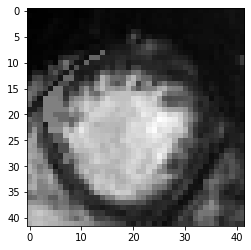

In [ ]:
plt.imshow(img_ED_syn[3,:,:], cmap="gray")

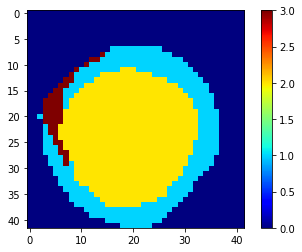

In [ ]:
plt.imshow(img_gt_ED_syn[3,:,:], cmap="jet")
plt.colorbar()

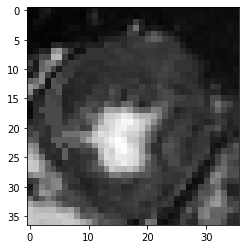

In [ ]:
plt.imshow(img_ES_syn[3,:,:], cmap="gray")

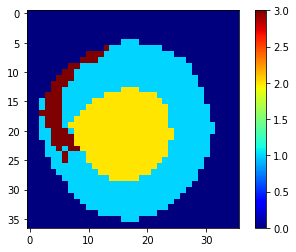

In [ ]:
plt.imshow(img_gt_ES_syn[3,:,:], cmap="jet")
plt.colorbar()

In [ ]:
img_new_syn_ED = sitk.GetImageFromArray(img_ED_syn)
img_new_syn_ED.CopyInformation(img_ED_org)
gt_new_syn_ED  = sitk.GetImageFromArray(img_gt_ED_syn)
gt_new_syn_ED.CopyInformation(img_gt_ED_org)
###
img_new_syn_ES = sitk.GetImageFromArray(img_ES_syn)
img_new_syn_ES.CopyInformation(img_ES_org)
gt_new_syn_ES = sitk.GetImageFromArray(img_gt_ES_syn)
gt_new_syn_ES.CopyInformation(img_gt_ES_org)
# Save the images and the segmentations
save_path_root = "/content/gdrive/MyDrive/Synthetic Data/syn_python/syn_scar/"
save_path_img_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED.nii.gz"
save_path_gt_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED_gt.nii.gz"
sitk.WriteImage(img_new_syn_ED, save_path_img_ED)
sitk.WriteImage(gt_new_syn_ED, save_path_gt_ED)
### ES
save_path_img_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES.nii.gz"
save_path_gt_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES_gt.nii.gz"
sitk.WriteImage(img_new_syn_ES, save_path_img_ES)
sitk.WriteImage(gt_new_syn_ES, save_path_gt_ES)

# **Thickened myocardium**

In [ ]:
acdc_selected = 19

In [ ]:
##### 

# ACDC:
# label 1: MYO
# label 2: LV Blood pool
##### ACDC
#ED
img_ED_org = nii_reader(images_acdc_ED[acdc_selected])
img_ED = sitk.GetArrayFromImage(img_ED_org)
img_gt_ED_org = nii_reader(segs_acdc_ED[acdc_selected])
img_gt_ED = sitk.GetArrayFromImage(img_gt_ED_org)
#ES
img_ES_org = nii_reader(images_acdc_ES[acdc_selected])
img_ES = sitk.GetArrayFromImage(img_ES_org)
img_gt_ES_org = nii_reader(segs_acdc_ES[acdc_selected])
img_gt_ES = sitk.GetArrayFromImage(img_gt_ES_org)


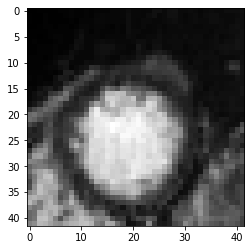

In [ ]:
plt.imshow(img_ED[4,:,:], cmap="gray")

In [ ]:
img_ED_syn = img_ED
img_gt_ED_syn = img_gt_ED
###
img_ES_syn = img_ES
img_gt_ES_syn = img_gt_ES
###
myo_ED = np.zeros(img_ED_syn.shape)
myo_ED[img_gt_ED==1]=img_gt_ED[img_gt_ED==1]
bp_ED = np.transpose(np.asanyarray(np.nonzero(myo_ED)))
bp_ED = list(bp_ED)
###
myo_ES = np.zeros(img_gt_ES_syn.shape)
myo_ES[img_gt_ES==1]=img_gt_ES[img_gt_ES==1]
bp_ES = np.transpose(np.asanyarray(np.nonzero(myo_ES)))
bp_ES = list(bp_ES)

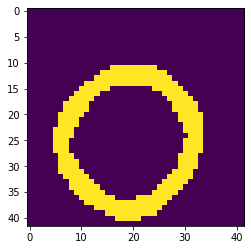

In [ ]:
plt.imshow(myo_ED[4,:,:])

In [ ]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
myo_ED_dilated = cv2.dilate(myo_ED,SE)

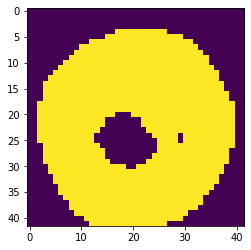

In [ ]:
plt.imshow(myo_ED_dilated[4,:,:])

In [ ]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
myo_ES_dilated = cv2.dilate(myo_ES,SE)

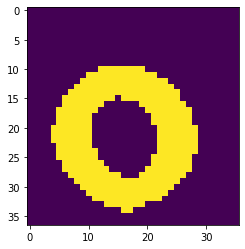

In [ ]:
plt.imshow(myo_ES[4,:,:])

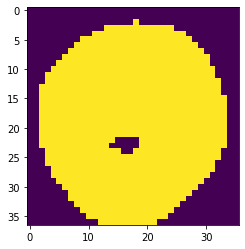

In [ ]:
plt.imshow(myo_ES_dilated[4,:,:])

In [ ]:
for i in range(img_ED_syn.shape[0]):
    #
   for j in range(img_ED_syn.shape[1]):
     for k in range(img_ED_syn.shape[2]):
         
         if myo_ED_dilated[i, j, k]==1:
            if myo_ED[i,j,k]==1:
               pass
            else:
             # if the detected pixel is in myocardium in the original image then change it
                bp_selected_ED = slice_getter(bp_ED, i)
                index_ED = np.argmin(np.sum((np.array(bp_selected_ED) - np.array([i, j, k]))**2, axis=1))
                a,b,c = bp_selected_ED[index_ED]
                img_ED_syn[i, j, k] = img_ED[i, b, c]# closest point myocardium
                img_gt_ED_syn[i,j,k] = 1
         else:
                pass
             
            
            #find nearest point in gt_ED == 2 and take that pixel
            
           # np.mean(img_ED[img_gt_ED==2]) - random.choice(range(np.min(img_ED[img_gt_ED==2])+30, np.max(img_ED[img_gt_ED==2])-100))

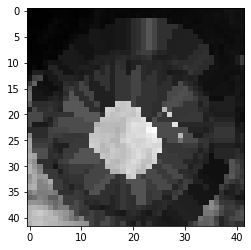

In [ ]:
plt.imshow(img_ED_syn[3,:,:], cmap="gray")

In [ ]:
for i in range(img_ES_syn.shape[0]):
    #
   for j in range(img_ES_syn.shape[1]):
     for k in range(img_ES_syn.shape[2]):
         
         if myo_ES_dilated[i, j, k]==1:
            if myo_ES[i,j,k]==1:
               pass
            else:
             # if the detected pixel is in myocardium in the original image then change it
                bp_selected_ES = slice_getter(bp_ES, i)
                index_ES = np.argmin(np.sum((np.array(bp_selected_ES) - np.array([i, j, k]))**2, axis=1))
                a,b,c = bp_selected_ES[index_ES]
                img_ES_syn[i, j, k] = img_ES[i, b, c]# closest point myocardium
                img_gt_ES_syn[i,j,k] = 1
         else:
                pass
             
            
            #find nearest point in gt_ED == 2 and take that pixel
            
           # np.mean(img_ED[img_gt_ED==2]) - random.choice(range(np.min(img_ED[img_gt_ED==2])+30, np.max(img_ED[img_gt_ED==2])-100))

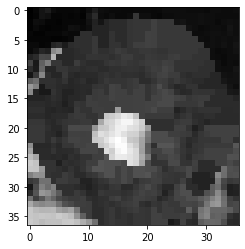

In [ ]:
plt.imshow(img_ES_syn[3,:,:], cmap="gray")

In [ ]:
img_new_syn_ED = sitk.GetImageFromArray(img_ED_syn)
img_new_syn_ED.CopyInformation(img_ED_org)
gt_new_syn_ED  = sitk.GetImageFromArray(img_gt_ED_syn)
gt_new_syn_ED.CopyInformation(img_gt_ED_org)
###
img_new_syn_ES = sitk.GetImageFromArray(img_ES_syn)
img_new_syn_ES.CopyInformation(img_ES_org)
gt_new_syn_ES = sitk.GetImageFromArray(img_gt_ES_syn)
gt_new_syn_ES.CopyInformation(img_gt_ES_org)
# Save the images and the segmentations
save_path_root = "/content/gdrive/MyDrive/Synthetic Data/syn_python/syn_dilated_myo/"
save_path_img_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED.nii.gz"
save_path_gt_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED_gt.nii.gz"
sitk.WriteImage(img_new_syn_ED, save_path_img_ED)
sitk.WriteImage(gt_new_syn_ED, save_path_gt_ED)
### ES
save_path_img_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES.nii.gz"
save_path_gt_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES_gt.nii.gz"
sitk.WriteImage(img_new_syn_ES, save_path_img_ES)
sitk.WriteImage(gt_new_syn_ES, save_path_gt_ES)

# **Thin myocardium [Removed]**

In [ ]:
acdc_selected = 1

In [ ]:
##### 

# ACDC:
# label 1: MYO
# label 2: LV Blood pool
##### ACDC
#ED
img_ED_org = nii_reader(images_acdc_ED[acdc_selected])
img_ED = sitk.GetArrayFromImage(img_ED_org)
img_gt_ED_org = nii_reader(segs_acdc_ED[acdc_selected])
img_gt_ED = sitk.GetArrayFromImage(img_gt_ED_org)
#ES
img_ES_org = nii_reader(images_acdc_ES[acdc_selected])
img_ES = sitk.GetArrayFromImage(img_ES_org)
img_gt_ES_org = nii_reader(segs_acdc_ES[acdc_selected])
img_gt_ES = sitk.GetArrayFromImage(img_gt_ES_org)


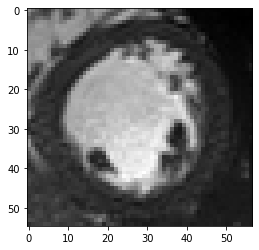

In [ ]:
plt.imshow(img_ED[4,:,:], cmap="gray")

In [ ]:
img_ED_syn = img_ED
img_gt_ED_syn = img_gt_ED
###
img_ES_syn = img_ES
img_gt_ES_syn = img_gt_ES
###
bloodpool_ED = np.zeros(img_ED_syn.shape)
bloodpool_ED[img_gt_ED==2]=img_gt_ED[img_gt_ED==2]
bp_ED = np.transpose(np.asanyarray(np.nonzero(bloodpool_ED)))
bp_ED = list(bp_ED)
###
bloodpool_ES = np.zeros(img_gt_ES_syn.shape)
bloodpool_ES[img_gt_ES==2]=img_gt_ES[img_gt_ES==2]
bp_ES = np.transpose(np.asanyarray(np.nonzero(bloodpool_ES)))
bp_ES = list(bp_ES)

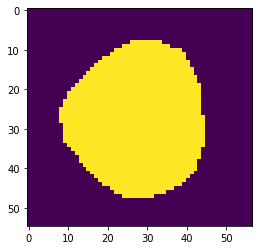

In [ ]:
plt.imshow(bloodpool_ED[4,:,:])

In [ ]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
bloodpool_ED_dilated = cv2.dilate(bloodpool_ED,SE)

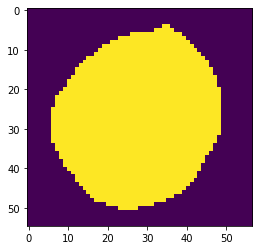

In [ ]:
plt.imshow(bloodpool_ED_dilated[4,:,:])

In [ ]:
SE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
bloodpool_ES_dilated = cv2.dilate(bloodpool_ES,SE)

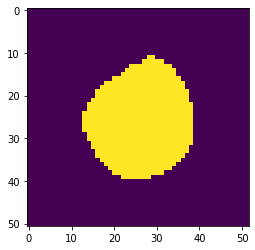

In [ ]:
plt.imshow(bloodpool_ES[4,:,:])

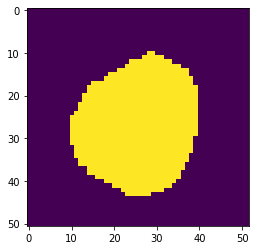

In [ ]:
plt.imshow(bloodpool_ES_dilated[4,:,:])

In [ ]:
for i in range(img_ED_syn.shape[0]):
    #
   for j in range(img_ED_syn.shape[1]):
     for k in range(img_ED_syn.shape[2]):
         
         if bloodpool_ED_dilated[i, j, k]==2:
            if bloodpool_ED[i,j,k]==2:
               pass
            else:
             # if the detected pixel is not in LV blood pool in the original image then change it
                bp_selected_ED = slice_getter(bp_ED, i)
                index_ED = np.argmin(np.sum((np.array(bp_selected_ED) - np.array([i, j, k]))**2, axis=1))
                a,b,c = bp_selected_ED[index_ED]
                img_ED_syn[i, j, k] = img_ED[i, b, c]# closest point myocardium
                img_gt_ED_syn[i,j,k] = 2
         else:
                pass
             
            
            #find nearest point in gt_ED == 2 and take that pixel
            
           # np.mean(img_ED[img_gt_ED==2]) - random.choice(range(np.min(img_ED[img_gt_ED==2])+30, np.max(img_ED[img_gt_ED==2])-100))

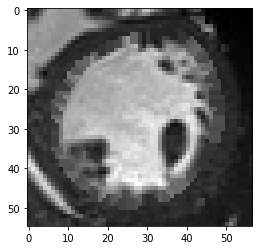

In [ ]:
plt.imshow(img_ED_syn[3,:,:], cmap="gray")

In [ ]:
for i in range(img_ES_syn.shape[0]):
    #
   for j in range(img_ES_syn.shape[1]):
     for k in range(img_ES_syn.shape[2]):
         
         if bloodpool_ES_dilated[i, j, k]==2:
            if bloodpool_ES[i,j,k]==2:
               pass
            else:
             # if the detected pixel is not in blood pool in the original image then change it
                bp_selected_ES = slice_getter(bp_ES, i)
                index_ES = np.argmin(np.sum((np.array(bp_selected_ES) - np.array([i, j, k]))**2, axis=1))
                a,b,c = bp_selected_ES[index_ES]
                img_ES_syn[i, j, k] = img_ES[i, b, c]# closest point myocardium
                img_gt_ES_syn[i,j,k] = 2
         else:
                pass
             
            
            #find nearest point in gt_ED == 2 and take that pixel
            
           # np.mean(img_ED[img_gt_ED==2]) - random.choice(range(np.min(img_ED[img_gt_ED==2])+30, np.max(img_ED[img_gt_ED==2])-100))

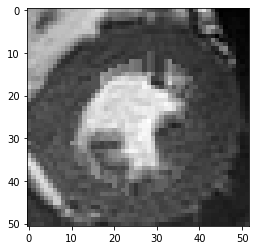

In [ ]:
plt.imshow(img_ES_syn[3,:,:], cmap="gray")

In [ ]:
img_new_syn_ED = sitk.GetImageFromArray(img_ED_syn)
img_new_syn_ED.CopyInformation(img_ED_org)
gt_new_syn_ED  = sitk.GetImageFromArray(img_gt_ED_syn)
gt_new_syn_ED.CopyInformation(img_gt_ED_org)
###
img_new_syn_ES = sitk.GetImageFromArray(img_ES_syn)
img_new_syn_ES.CopyInformation(img_ES_org)
gt_new_syn_ES = sitk.GetImageFromArray(img_gt_ES_syn)
gt_new_syn_ES.CopyInformation(img_gt_ES_org)
# Save the images and the segmentations
save_path_root = "/content/gdrive/MyDrive/Synthetic Data/syn_python/syn_thin_myo/"
save_path_img_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED.nii.gz"
save_path_gt_ED = save_path_root + "patient" + "%d"%acdc_selected + "_ED_gt.nii.gz"
sitk.WriteImage(img_new_syn_ED, save_path_img_ED)
sitk.WriteImage(gt_new_syn_ED, save_path_gt_ED)
### ES
save_path_img_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES.nii.gz"
save_path_gt_ES = save_path_root + "patient" + "%d"%acdc_selected + "_ES_gt.nii.gz"
sitk.WriteImage(img_new_syn_ES, save_path_img_ES)
sitk.WriteImage(gt_new_syn_ES, save_path_gt_ES)